In [19]:
# Clean, Colab-friendly setup (no deprecated packages)
!pip -q install transformers[sentencepiece] datasets rouge-score PyPDF2 sentencepiece nltk

# Disable noisy output and warnings
import os, warnings
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

print("Setup complete — all required packages installed, warnings and progress bars suppressed.")


Setup complete — all required packages installed, warnings and progress bars suppressed.


In [6]:
# Cell 2 — Imports & basic utilities
import time
import math
import json
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt

# standard libs for PDFs and NLP
import PyPDF2
import nltk
nltk.download('punkt', quiet=True)  # sentence tokenizer
from nltk.tokenize import sent_tokenize

# Hugging Face pipeline and tools
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

# For evaluation
from rouge_score import rouge_scorer

# helper: read pages from PDF (1-indexed page numbers)
def extract_text_from_pdf(path: str, start_page: int, end_page: int) -> str:
    """
    Extract text from start_page to end_page inclusive.
    Pages are 1-indexed (if you pass start_page=1 it's the first page).
    """
    text_parts = []
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        num_pages = len(reader.pages)
        # clamp
        s = max(1, start_page)
        e = min(end_page, num_pages)
        for p in range(s-1, e):
            page = reader.pages[p]
            page_text = page.extract_text() or ""
            text_parts.append(page_text)
    return "\n".join(text_parts)


In [7]:
# Cell 3 — File paths: show your uploaded PDFs and example start/end indexes
# Change the start/end pages as needed.

pdfs = {
    "Tanenbaum": {
        "path": "/content/sample_data/Andrew S. Tanenbaum - Computer Networks.pdf",
        "start_page": 1,
        "end_page": 8
    },
    "Neuroscience": {
        "path": "/content/sample_data/Neuroscience.pdf",
        "start_page": 1,
        "end_page": 8
    }
}

# Quick sanity check that files exist
for name, info in pdfs.items():
    p = Path(info["path"])
    print(f"{name}: {p.exists()} -> {info['path']} (pages {info['start_page']}–{info['end_page']})")


Tanenbaum: True -> /content/sample_data/Andrew S. Tanenbaum - Computer Networks.pdf (pages 1–8)
Neuroscience: True -> /content/sample_data/Neuroscience.pdf (pages 1–8)


In [8]:
# Cell 4 — Load text from PDFs (using start/end indexes) into variables
docs = {}
for name, info in pdfs.items():
    text = extract_text_from_pdf(info["path"], info["start_page"], info["end_page"])
    # basic cleaning
    text = "\n".join([line.strip() for line in text.splitlines() if line.strip()])
    docs[name] = text[:200000]  # safety cap (don't push massive text into a single call)
    print(f"{name}: loaded {len(docs[name])} characters")


Tanenbaum: loaded 3129 characters
Neuroscience: loaded 5084 characters


In [10]:
# Cell 5 — Chunking utility
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

def chunk_text(text: str, max_sentences: int = 12):
    sents = nltk.sent_tokenize(text)
    chunks = []
    cur = []
    for sent in sents:
        cur.append(sent)
        if len(cur) >= max_sentences:
            chunks.append(" ".join(cur))
            cur = []
    if cur:
        chunks.append(" ".join(cur))
    return chunks

# Example: show chunk count for each doc
for name, text in docs.items():
    chunks = chunk_text(text, max_sentences=10)
    print(f"{name}: {len(chunks)} chunks (first chunk length {len(chunks[0]) if chunks else 0} chars)")


Tanenbaum: 2 chunks (first chunk length 2657 chars)
Neuroscience: 5 chunks (first chunk length 977 chars)


In [20]:
# Cell 6 — Model configuration (Summarization + Paraphrasing)
# -------------------------------------------------------------

# Summarization models
summ_models = {
    "t5-base": "t5-base",
    "bart-base": "facebook/bart-base",
    "pegasus-xsum": "google/pegasus-xsum"
}

# Paraphrasing models
# Note: community checkpoints used for paraphrasing
paraphrase_models = {
    "t5-paraphrase": "Vamsi/T5_Paraphrase_Paws",               # T5-based paraphrase
    "bart-paraphrase": "eugenesiow/bart-paraphrase",           # BART-based paraphrase
    "pegasus-paraphrase": "ramsrigouthamg/pegasus_paraphrase"  # Pegasus-based paraphrase
}

# Choose GPU if available
import torch
device = 0 if torch.cuda.is_available() else -1
print(f" Using device: {'GPU' if device==0 else 'CPU'}")

# Optional check
print("\nSummarization Models:")
for k, v in summ_models.items():
    print(f"  {k:20s} -> {v}")

print("\nParaphrasing Models:")
for k, v in paraphrase_models.items():
    print(f"  {k:20s} -> {v}")


 Using device: CPU

Summarization Models:
  t5-base              -> t5-base
  bart-base            -> facebook/bart-base
  pegasus-xsum         -> google/pegasus-xsum

Paraphrasing Models:
  t5-paraphrase        -> Vamsi/T5_Paraphrase_Paws
  bart-paraphrase      -> eugenesiow/bart-paraphrase
  pegasus-paraphrase   -> ramsrigouthamg/pegasus_paraphrase


In [21]:
# Cell 7 — Load summarization models (T5, BART, Pegasus)
# ------------------------------------------------------

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

summ_pipelines = {}

print(" Loading summarization models... please wait (this may take 1–2 min first time)")

for label, model_id in summ_models.items():
    try:
        print(f"→ {label}: loading {model_id}")
        tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
        m = AutoModelForSeq2SeqLM.from_pretrained(model_id)
        summ_pipelines[label] = pipeline(
            "summarization",
            model=m,
            tokenizer=tok,
            device=device
        )
        print(f"    {label} ready.")
    except Exception as e:
        print(f"   Failed to load {label}: {e}")

print("\n All summarization pipelines initialized.")


 Loading summarization models... please wait (this may take 1–2 min first time)
→ t5-base: loading t5-base
    t5-base ready.
→ bart-base: loading facebook/bart-base
    bart-base ready.
→ pegasus-xsum: loading google/pegasus-xsum
    pegasus-xsum ready.

 All summarization pipelines initialized.


In [13]:
# Cell 8 — Load paraphrasing models (T5, BART, Pegasus)
# ------------------------------------------------------

paraphrase_pipelines = {}

print("🔹 Loading paraphrasing models... please wait")

for label, model_id in paraphrase_models.items():
    try:
        print(f"→ {label}: loading {model_id}")
        tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
        m = AutoModelForSeq2SeqLM.from_pretrained(model_id)
        paraphrase_pipelines[label] = pipeline(
            "text2text-generation",
            model=m,
            tokenizer=tok,
            device=device
        )
        print(f"    {label} ready.")
    except Exception as e:
        print(f"   Failed to load {label}: {e}")

print("\n All paraphrasing pipelines initialized.")


🔹 Loading paraphrasing models... please wait
→ t5-paraphrase: loading Vamsi/T5_Paraphrase_Paws
    t5-paraphrase ready.
→ bart-paraphrase: loading eugenesiow/bart-paraphrase
    bart-paraphrase ready.
→ pegasus-paraphrase: loading ramsrigouthamg/pegasus_paraphrase
   Failed to load pegasus-paraphrase: ramsrigouthamg/pegasus_paraphrase is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

 All paraphrasing pipelines initialized.


In [14]:
# Cell 9 — Run summarization for each document and model
# ------------------------------------------------------

import time
from tqdm.notebook import tqdm
from rouge_score import rouge_scorer

# Initialize results dictionary
results = {}

# Initialize ROUGE scorer for later comparison
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

print(" Running summarization on all documents and models...")

for doc_name, text in docs.items():
    chunks = chunk_text(text, max_sentences=10)
    results[doc_name] = {}

    print(f"\n Document: {doc_name} ({len(chunks)} chunks)")
    for model_label, pipe in summ_pipelines.items():
        print(f"→ Summarizing with {model_label} ...")
        start_time = time.time()

        summaries = []
        for ch in tqdm(chunks, desc=f"{model_label}", leave=False):
            try:
                out = pipe(ch, max_length=150, min_length=30, truncation=True)[0]['summary_text']
            except Exception:
                out = pipe(ch, max_length=100, min_length=20, truncation=True)[0]['summary_text']
            summaries.append(out)

        total_summary = "\n".join(summaries)
        elapsed = time.time() - start_time

        results[doc_name][model_label] = {
            "summary": total_summary,
            "time_sec": elapsed,
            "chunk_count": len(chunks)
        }

        print(f"    {model_label} done in {elapsed:.1f}s | {len(total_summary)} chars")


 Running summarization on all documents and models...

 Document: Tanenbaum (2 chunks)
→ Summarizing with t5-base ...


t5-base:   0%|          | 0/2 [00:00<?, ?it/s]

    t5-base done in 25.0s | 335 chars
→ Summarizing with bart-base ...


bart-base:   0%|          | 0/2 [00:00<?, ?it/s]

    bart-base done in 56.8s | 1672 chars
→ Summarizing with pegasus-xsum ...


pegasus-xsum:   0%|          | 0/2 [00:00<?, ?it/s]

    pegasus-xsum done in 26.9s | 294 chars

 Document: Neuroscience (5 chunks)
→ Summarizing with t5-base ...


t5-base:   0%|          | 0/5 [00:00<?, ?it/s]

    t5-base done in 53.9s | 949 chars
→ Summarizing with bart-base ...


bart-base:   0%|          | 0/5 [00:00<?, ?it/s]

    bart-base done in 116.7s | 3212 chars
→ Summarizing with pegasus-xsum ...


pegasus-xsum:   0%|          | 0/5 [00:00<?, ?it/s]

    pegasus-xsum done in 106.0s | 1291 chars


In [15]:
# Cell 10 — Run paraphrasing for all summaries
# --------------------------------------------

print("\n Running paraphrasing on generated summaries...")

paraphrase_results = {}

for doc_name in results:
    paraphrase_results[doc_name] = {}
    print(f"\n Document: {doc_name}")

    for summ_model, summ_data in results[doc_name].items():
        summary_text = summ_data["summary"]
        paraphrase_results[doc_name][summ_model] = {}

        for para_label, para_pipe in paraphrase_pipelines.items():
            print(f"→ {summ_model} → paraphrased by {para_label}")
            start_time = time.time()

            # Chunk long summaries to prevent truncation
            parts = [summary_text[i:i+1800] for i in range(0, len(summary_text), 1800)]
            paraphrased_parts = []

            for p in tqdm(parts, desc=f"{para_label}", leave=False):
                try:
                    output = para_pipe(p, max_length=512, truncation=True)[0]
                    text = output.get('generated_text') or output.get('summary_text') or str(output)
                except Exception as e:
                    text = f"[ERROR: {str(e)}]"
                paraphrased_parts.append(text)

            full_paraphrase = "\n".join(paraphrased_parts)
            elapsed = time.time() - start_time

            paraphrase_results[doc_name][summ_model][para_label] = {
                "paraphrase": full_paraphrase,
                "time_sec": elapsed
            }

            print(f"   Paraphrased by {para_label} in {elapsed:.1f}s | {len(full_paraphrase)} chars")



 Running paraphrasing on generated summaries...

 Document: Tanenbaum
→ t5-base → paraphrased by t5-paraphrase


t5-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by t5-paraphrase in 19.1s | 337 chars
→ t5-base → paraphrased by bart-paraphrase


bart-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by bart-paraphrase in 18.9s | 247 chars
→ bart-base → paraphrased by t5-paraphrase


t5-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by t5-paraphrase in 21.9s | 195 chars
→ bart-base → paraphrased by bart-paraphrase


bart-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by bart-paraphrase in 44.3s | 484 chars
→ pegasus-xsum → paraphrased by t5-paraphrase


t5-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by t5-paraphrase in 11.5s | 295 chars
→ pegasus-xsum → paraphrased by bart-paraphrase


bart-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by bart-paraphrase in 12.2s | 172 chars

 Document: Neuroscience
→ t5-base → paraphrased by t5-paraphrase


t5-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by t5-paraphrase in 21.4s | 317 chars
→ t5-base → paraphrased by bart-paraphrase


bart-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by bart-paraphrase in 26.2s | 297 chars
→ bart-base → paraphrased by t5-paraphrase


t5-paraphrase:   0%|          | 0/2 [00:00<?, ?it/s]

   Paraphrased by t5-paraphrase in 46.9s | 650 chars
→ bart-base → paraphrased by bart-paraphrase


bart-paraphrase:   0%|          | 0/2 [00:00<?, ?it/s]

   Paraphrased by bart-paraphrase in 81.1s | 670 chars
→ pegasus-xsum → paraphrased by t5-paraphrase


t5-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by t5-paraphrase in 20.9s | 429 chars
→ pegasus-xsum → paraphrased by bart-paraphrase


bart-paraphrase:   0%|          | 0/1 [00:00<?, ?it/s]

   Paraphrased by bart-paraphrase in 14.4s | 154 chars


In [22]:
# Cell 11 — Evaluate summarization performance using ROUGE
# --------------------------------------------------------

print("\n🔹 Evaluating model performance (ROUGE + time + length)...")

eval_results = {}

for doc_name, text in docs.items():
    eval_results[doc_name] = {}
    ref = " ".join(sent_tokenize(text)[:40])  # take first 40 sentences as reference

    for model_label, data in results[doc_name].items():
        summary = data["summary"]
        scores = scorer.score(ref, summary)

        eval_results[doc_name][model_label] = {
            "ROUGE-1": scores["rouge1"].fmeasure,
            "ROUGE-2": scores["rouge2"].fmeasure,
            "ROUGE-L": scores["rougeL"].fmeasure,
            "Time (s)": data["time_sec"],
            "Length": len(summary)
        }

# Display results neatly
for doc_name, models in eval_results.items():
    print(f"\n Evaluation Results — {doc_name}")
    print(f"{'Model':20s} | {'R1':>6s} | {'R2':>6s} | {'RL':>6s} | {'Time(s)':>8s} | {'Length':>8s}")
    print("-"*70)
    for m, v in models.items():
        print(f"{m:20s} | {v['ROUGE-1']:.3f} | {v['ROUGE-2']:.3f} | {v['ROUGE-L']:.3f} | {v['Time (s)']:.1f} | {v['Length']}")



🔹 Evaluating model performance (ROUGE + time + length)...

 Evaluation Results — Tanenbaum
Model                |     R1 |     R2 |     RL |  Time(s) |   Length
----------------------------------------------------------------------
t5-base              | 0.172 | 0.136 | 0.164 | 25.0 | 335
bart-base            | 0.475 | 0.378 | 0.460 | 56.8 | 1672
pegasus-xsum         | 0.118 | 0.016 | 0.073 | 26.9 | 294

 Evaluation Results — Neuroscience
Model                |     R1 |     R2 |     RL |  Time(s) |   Length
----------------------------------------------------------------------
t5-base              | 0.307 | 0.249 | 0.226 | 53.9 | 949
bart-base            | 0.667 | 0.539 | 0.536 | 116.7 | 3212
pegasus-xsum         | 0.211 | 0.054 | 0.138 | 106.0 | 1291


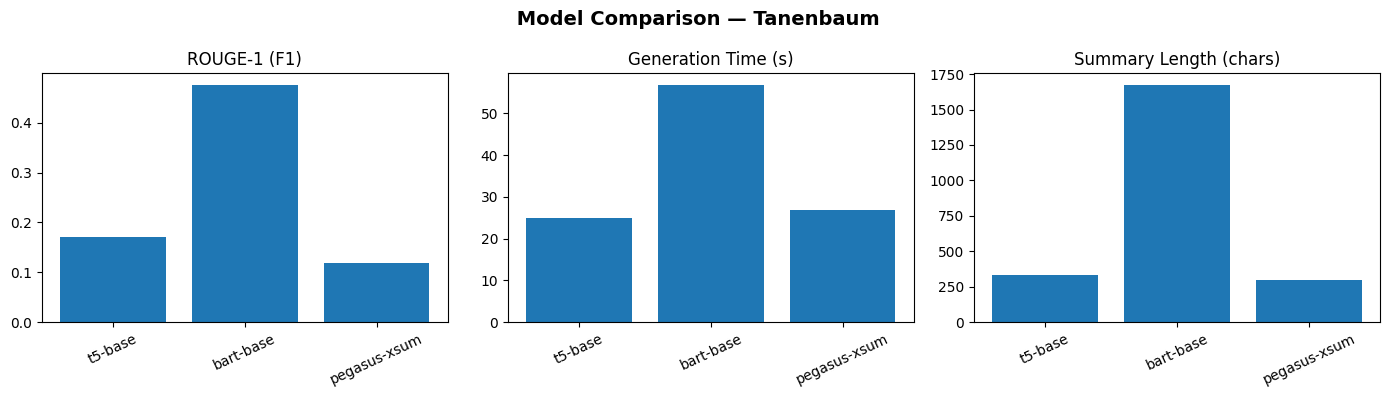

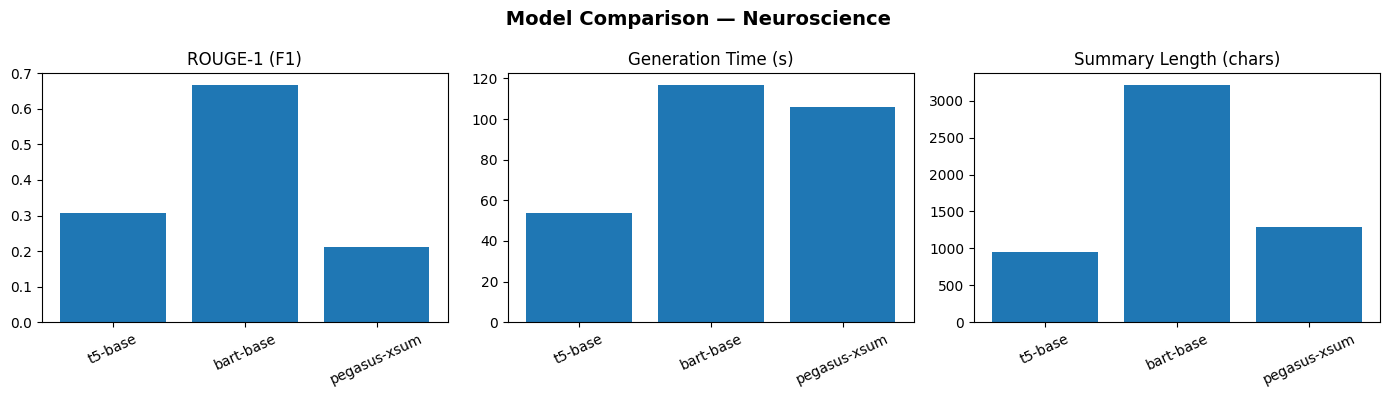

In [17]:
# Cell 12 — Visualize model performance
# -------------------------------------

import matplotlib.pyplot as plt

for doc_name, vals in eval_results.items():
    labels = list(vals.keys())
    rouge1 = [vals[m]['ROUGE-1'] for m in labels]
    rouge2 = [vals[m]['ROUGE-2'] for m in labels]
    rougeL = [vals[m]['ROUGE-L'] for m in labels]
    times = [vals[m]['Time (s)'] for m in labels]
    lengths = [vals[m]['Length'] for m in labels]

    plt.figure(figsize=(14, 4))
    plt.suptitle(f" Model Comparison — {doc_name}", fontsize=14, weight='bold')

    # ROUGE-1
    plt.subplot(1, 3, 1)
    plt.bar(labels, rouge1)
    plt.title("ROUGE-1 (F1)")
    plt.xticks(rotation=25)

    # Time
    plt.subplot(1, 3, 2)
    plt.bar(labels, times)
    plt.title("Generation Time (s)")
    plt.xticks(rotation=25)

    # Length
    plt.subplot(1, 3, 3)
    plt.bar(labels, lengths)
    plt.title("Summary Length (chars)")
    plt.xticks(rotation=25)

    plt.tight_layout()
    plt.show()


In [18]:
# Cell 13 — Display and Save all Summaries and Paraphrases
# --------------------------------------------------------

from pathlib import Path
from IPython.display import display, HTML

output_dir = Path("/content/textmorph_outputs")
output_dir.mkdir(parents=True, exist_ok=True)

def format_preview(text, max_chars=800):
    """Return a clean preview with truncation for readability."""
    text = text.strip().replace('\n', ' ')
    if len(text) > max_chars:
        return text[:max_chars] + " ... [truncated]"
    return text

html_output = "<h2> TextMorph Summaries & Paraphrases</h2>"

for doc_name, model_data in results.items():
    html_output += f"<h3> Document: {doc_name}</h3>"

    # --- Summaries ---
    html_output += "<h4>Summaries:</h4>"
    for model_label, data in model_data.items():
        summary = data['summary']
        fname = output_dir / f"{doc_name}__{model_label}__summary.txt"
        fname.write_text(summary, encoding='utf-8')

        html_output += f"<b>{model_label}</b><br>"
        html_output += f"<pre style='background:#f7f7f7;padding:10px;border-radius:8px'>{format_preview(summary)}</pre>"

    # --- Paraphrases ---
    html_output += "<h4>Paraphrases:</h4>"
    for summ_model, para_data in paraphrase_results[doc_name].items():
        for para_model, pinfo in para_data.items():
            paraphrase_text = pinfo['paraphrase']
            fname = output_dir / f"{doc_name}__{summ_model}__paraphrased_by__{para_model}.txt"
            fname.write_text(paraphrase_text, encoding='utf-8')

            html_output += f"<b>{summ_model} → {para_model}</b><br>"
            html_output += f"<pre style='background:#eef7ff;padding:10px;border-radius:8px'>{format_preview(paraphrase_text)}</pre>"

html_output += f"<p> All outputs saved in <code>{output_dir}</code></p>"

display(HTML(html_output))
